# Differentiation

Recall that a derivative measures the rate of change of a function
$$ \frac{df}{dx} = \lim_{h\to 0} \frac{f(x+h)-f(x)}{h}$$
For a functions of multiple variables we also have the partial derivative
$$ \frac{\partial f}{\partial x_i} = \lim_{h\to 0} \frac{f(x+h e_i)-f(x)}{h}$$
the **gradient**
$$ \nabla f = \begin{bmatrix} \frac{\partial f}{\partial x_1} ,\frac{\partial f}{\partial x_2},\ldots\end{bmatrix}^T$$
and the **Hessian**
$$ H = \left[\frac{\partial^2 f}{\partial x_i\partial x_j} \right]_{i,j}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp

# Numerical differentiation

## Finite differences
The simplest way to numerically approximate a derivative is by approximating the above limit. This is called a "finite difference method".

The three simplest finite difference methods are the **forward difference**
$$ f'(x) \approx \frac{f(x+h) - f(x)}{h}$$
the **backwards difference**
$$ f'(x) \approx \frac{f(x) - f(x-h)}{h}$$
and the **central difference**
$$ f'(x) \approx \frac{f(x+h) - f(x-h)}{2h}$$

In [2]:
def forward_diff(f,x,h=1e-8):
    return (f(x+h)-f(x))/h

def backward_diff(f,x,h=1e-8):
    return (f(x)-f(x-h))/h

def central_diff(f,x,h=1e-8):
    return (f(x+h)-f(x-h))/h/2.

g = lambda x: exp(-x)*x*(x-1)
gp = lambda x: exp(-x)*(-x*(x-1)+(x-1)+x)

x0 = 0.2
print("True value : {}".format(gp(x0)))
for diff in [forward_diff, backward_diff, central_diff]:
    print("{} : {}".format(diff.__name__, diff(g,x0,1e-3)))

True value : -0.36024153135431203
forward_diff : -0.3589981026411726
backward_diff : -0.36148704510211016
central_diff : -0.3602425738716414


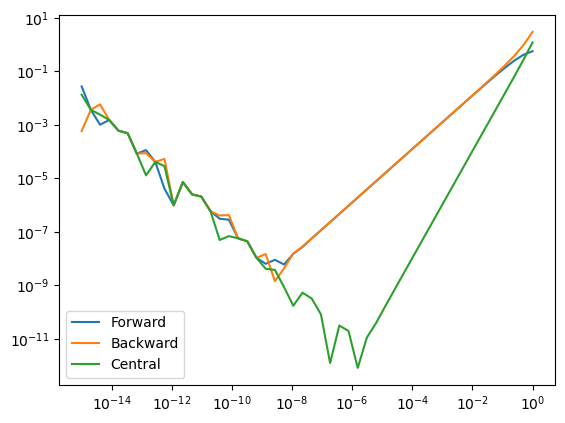

In [3]:
hs = np.logspace(-15,0)
errs = np.zeros([3,len(hs)])
for i in range(len(hs)):
    errs[0,i] = abs(forward_diff(g,x0,hs[i])-gp(x0))
    errs[1,i] = abs(backward_diff(g,x0,hs[i])-gp(x0))
    errs[2,i] = abs(central_diff(g,x0,hs[i])-gp(x0))
    
plt.loglog(hs,errs.T)
plt.legend(['Forward', 'Backward', 'Central'])

Let's look at the errors

In [4]:
for diff in [forward_diff, backward_diff, central_diff]:
    print("Error in {} : {}".format(diff.__name__, abs(diff(g,x0,1e-5)-gp(x0))))

Error in forward_diff : 1.2444602716488173e-05
Error in backward_diff : 1.244481003653819e-05
Error in central_diff : 1.0366002500816762e-10


We see the central difference gives a better approximation. This is due to the fact that when $f$ is smooth, we have that
$$ f'(x) = \frac{f(x+h) - f(x)}{h} + O(h)$$

$$ f'(x) \approx \frac{f(x) - f(x-h)}{h} + O(h)$$

$$ f'(x) \approx \frac{f(x+h) - f(x-h)}{2h} + O(h^2)$$

# Numerical Differentiation on a Grid
Suppose we have a function on a grid

In [5]:
g = lambda x: np.sin(3*x)#*exp(-x*x)
xs = np.linspace(-5,5,400)
h = 10/99
gx = g(xs)

What if we want to evaluate the derivative at each point on the grid?

`numpy` provides a function to efficiently compute this using differences: `diff`. This is equivalent to

    np.array([gx[i+1] - gx[i] for i in range(len(gx) - 1)])

In order to approximate the derivative using a forward difference, we simply divide by $h$. Note that we can't use the forward difference to approximate value at the last grid point.

In [6]:
np.linalg.norm(np.array([gx[i+1] - gx[i] for i in range(len(gx) - 1)]) - np.diff(gx))

0.0

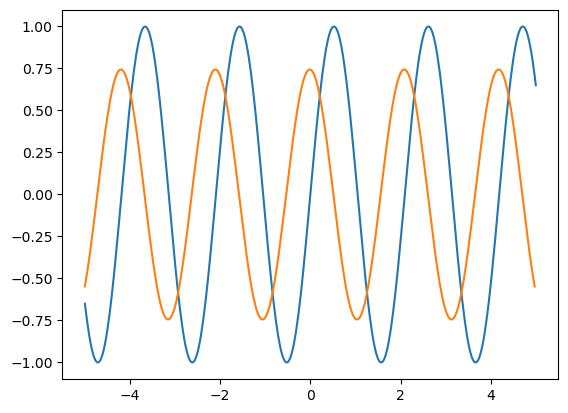

In [7]:
import matplotlib.pyplot as plt
g1 = np.diff(gx)/h
plt.plot(xs,gx)
plt.plot(xs[:-1],g1) # plot must exclude end point
plt.show()

The forward differnce operator can be expressed as applying the sparse matrix
$$ A = \frac1h \begin{pmatrix} -1 & 1 &&0 \\  & -1 & 1 &\\ & &-1 &1 & \\ 0&&& \ddots\end{pmatrix}$$
which could be implemented using the `linearoperator` class or the sparse matrix classes from earlier lectures

In [8]:
import scipy.sparse as sparse

In [9]:
# create the forward difference matrix A, equivalent to np.diff
def forward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)
        
        i.append(k)
        j.append(k+1)
        data.append(1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data,(i,j)),shape=(n,n)).tocsr()

D = forward_diff_matrix(len(gx))/h
D.toarray()

array([[-9.9,  9.9,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , -9.9,  9.9, ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -9.9, ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., -9.9,  9.9,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. , -9.9,  9.9],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

Equivalently, we could also use the `linearoperator` class:

In [10]:
n = len(gx)
forward_fun = lambda x: np.hstack([np.diff(x)/h, 0])
forward_fun2 = lambda x: np.vstack([np.diff(x,axis=0)/h, np.zeros(x.shape[1]).T])
Dop = sparse.linalg.LinearOperator(shape = (n,n), matvec = forward_fun, matmat = forward_fun2)

Dop @ np.eye(n)

array([[-9.9,  9.9,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , -9.9,  9.9, ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -9.9, ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., -9.9,  9.9,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. , -9.9,  9.9],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

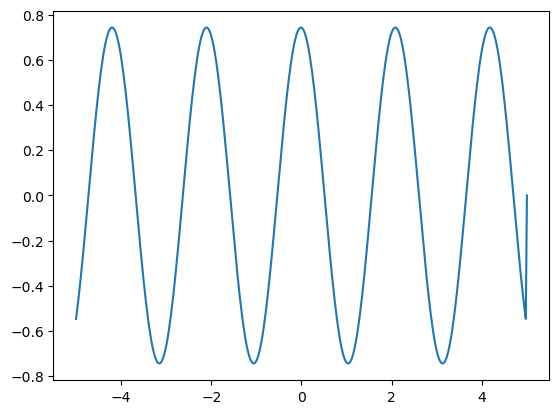

In [11]:
gx1 = D@gx
plt.plot(xs,gx1)
plt.show()

Note that difference schemes can't compute the derivate at the two end points.

One approach is to use 

    * Central difference in the interior
    * Forward difference at the left
    * Back difference at the right

In [12]:
# create the forward difference matrix A, equivalent to np.diff
def diff_matrix(n):
    data = []
    i = []
    j = []
    
    # forward on the left
    i.append(0)
    j.append(0)
    data.append(-1)
    
    i.append(0)
    j.append(1)
    data.append(1)
    
    # central in the middle
    for k in range(1,n - 1):
        i.append(k)
        j.append(k-1)
        data.append(-0.5)
        
        i.append(k)
        j.append(k+1)
        data.append(0.5)
        
    # backward on the right
    # forward on the left
    i.append(n-1)
    j.append(n-1)
    data.append(1)
    
    i.append(n-1)
    j.append(n-2)
    data.append(-1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data,(i,j)),shape=(n,n)).tocsr()

D = diff_matrix(len(gx))/h
D.toarray()

array([[-9.9 ,  9.9 ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-4.95,  0.  ,  4.95, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -4.95,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  4.95,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., -4.95,  0.  ,  4.95],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -9.9 ,  9.9 ]])

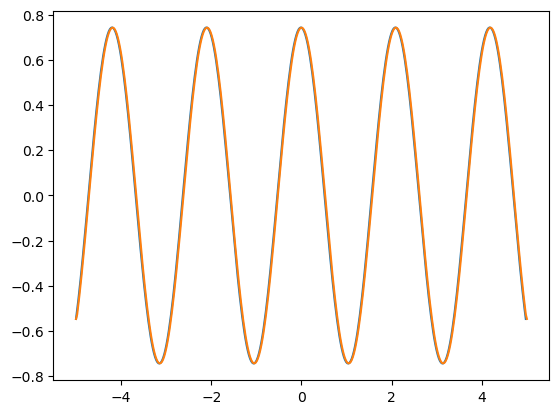

In [13]:
gx1 = D*gx
plt.plot(xs[:-1],g1)
plt.plot(xs,gx1)
plt.show()

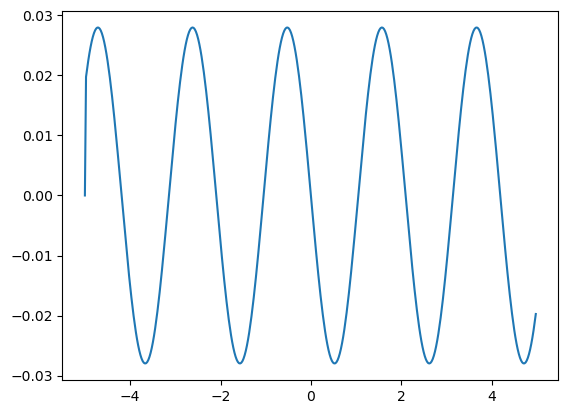

In [14]:
plt.plot(xs[:-1],g1-gx1[:-1])

There are also more complicated difference formulas. We could, for example, achieve more accuracy on the right using the so-called BDF2 formula

$$ f'(x) \approx \frac{f(x) - \frac43 f(x-h) + \frac13 f(x-2h)}{\frac23 h}+O(h^2)$$

Finite difference schemes are designed by choosing a "stencil" (the required function values) and then finding the coefficients that work through Taylor series calculations.

# Higher order derivatives
For simplicity, we'll use the square matrix above

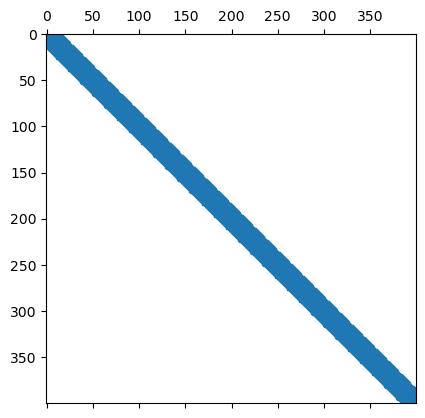

In [15]:
D1 = diff_matrix(len(gx))
plt.spy(D1)

Because differentiation is linear, we can compute second derivatives by repeatedly applying the above derivative operator

In [16]:
# second derivative
D2 = D1 @ D1

In [17]:
# third derivative
D3 = D1 @ D2

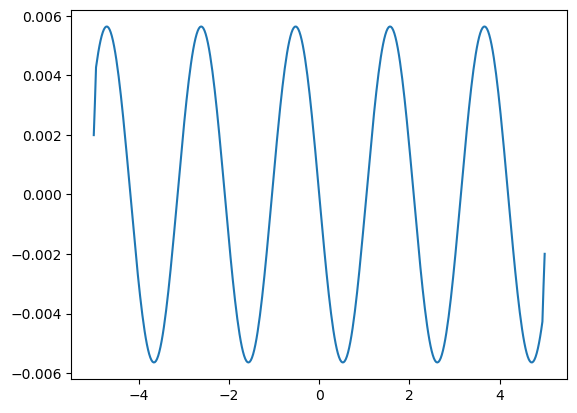

In [18]:
gx2 = D2 @ gx
plt.plot(xs,gx2)
plt.show()

In [19]:
D2[:8,:8].todense()*4

matrix([[ 2., -4.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 2., -3.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 1.,  0., -2.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  1.,  0., -2.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0., -2.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0., -2.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -2.]])

What we are seeing here is that repeatedly applying the central difference gives

$$ f''(x)\approx \frac{f(x+2h)-2 f(x) + f(x-2h)}{4h^2} $$

If we applied forward and then backwards difference, we would find that

$$ f''(x)\approx \frac{f(x+h)-2 f(x) + f(x-h)}{h^2} $$

# Other differentiation strategies

## Richardson extrapolation
Black board.


## Differenting a series expansion
Our idea will be to approximate $f$ in a basis and the differentiate the basis. For example, if 
$$ f(x) \approx a_0 + \sum_{n=1}^N a_n \sin(nx) + b_n \cos(nx)$$
then
$$ f'(x) \approx \sum_{n=1}^N n a_n \cos(nx) - nb_n \sin(nx)$$

# Higher dimensional grids

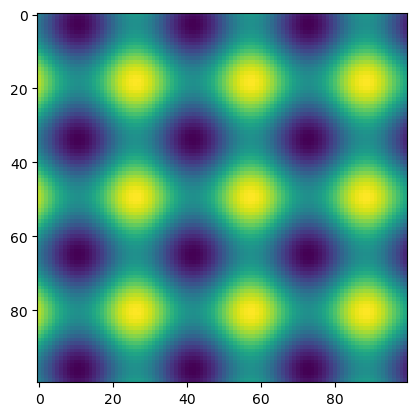

In [20]:
xx, yy = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
g2d = np.sin(xx) + np.cos(yy)
plt.imshow(g2d)
plt.show()

We will create an operator that will act as a derivative on the function treated as a vector

In [21]:
# turn 2-dimensional function ot a vector
g = g2d.flatten()

Recall that numpy arrays are row-major by default. This means that if we want to compute derivatives in the $x$ direction, we can simply create a block matrix with a derivative operator for each block in a contiguous row.

`numpy.sparse.kron` is a very useful function to create such a sparse matrix.

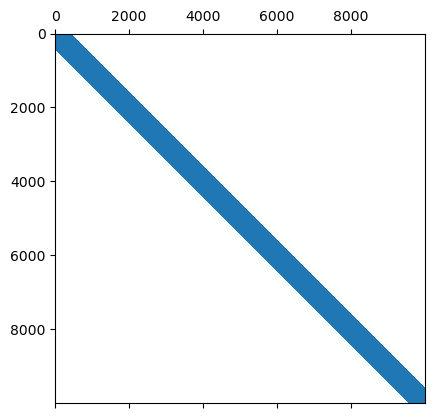

In [22]:
D = diff_matrix(100)
Dx = sparse.kron(sparse.eye(100),D).tocsr()
plt.spy(Dx)

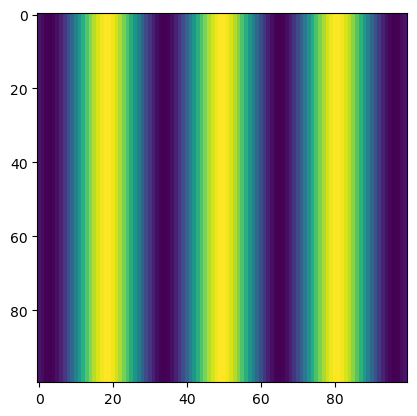

In [23]:
gx = Dx @ g
plt.imshow(gx.reshape(100,100))

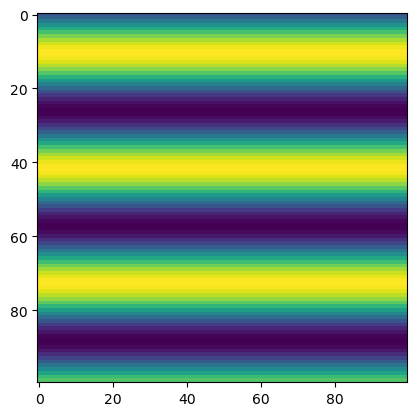

In [24]:
Dy = sparse.kron(D,sparse.eye(100)).tocsr()
# plt.spy(Dy)
gy = Dy @ g
plt.imshow(gy.reshape(100,100))

### Exercise: The Laplacian

Use the above ideas to numerically approximate the Laplacian
$$ \Delta := \frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}$$